
# 📊 Tema de Statistica – Analiza Datasetului de Weightlifting



## Pasul 0: Importuri si incarcarea setului de date

Datasetul: `weightlifting_721_workouts.csv` (date despre antrenamente, exercitii, greutate, repetari etc.).


In [23]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# incarcare dataset Weightlifting
df = pd.read_csv('../DataSet/weightlifting_721_workouts.csv')

# Conversie Date la tip datetime
df['Date'] = pd.to_datetime(df['Date'])

# Afisare primele rânduri si informatii de baza
df.head()

,Date,Workout Name,Exercise Name,Set Order,Weight,Reps,Distance,Seconds,Notes,Workout Notes
0,2015-10-23 17:06:37,Chest,Incline Bench Press (Barbell),1,135.0,8,0.0,0,NaN,NaN
1,2015-10-23 17:06:37,Chest,Incline Bench Press (Barbell),2,135.0,8,0.0,0,NaN,NaN
2,2015-10-23 17:06:37,Chest,Incline Bench Press (Barbell),3,135.0,5,0.0,0,NaN,NaN
3,2015-10-23 17:06:37,Chest,Incline Bench Press (Barbell),4,185.0,7,0.0,0,NaN,NaN
4,2015-10-23 17:06:37,Chest,Incline Bench Press (Barbell),5,230.0,8,0.0,0,NaN,NaN


In [24]:
# Informatii despre dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9932 entries, 0 to 9931
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9932 non-null   datetime64[ns]
 1   Workout Name   9932 non-null   object        
 2   Exercise Name  9932 non-null   object        
 3   Set Order      9932 non-null   int64         
 4   Weight         9932 non-null   float64       
 5   Reps           9932 non-null   int64         
 6   Distance       9932 non-null   float64       
 7   Seconds        9932 non-null   int64         
 8   Notes          7 non-null      object        
 9   Workout Notes  3 non-null      object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 776.1+ KB



## Explorare initiala si preprocesare

1. Verificam valorile lipsa.
2. Observam distributia exercitiilor si variabilele numerice.


In [25]:
# Verificare valori lipsa
df.isnull().sum()

Date                0
Workout Name        0
Exercise Name       0
Set Order           0
Weight              0
Reps                0
Distance            0
Seconds             0
Notes            9925
Workout Notes    9929
dtype: int64

In [26]:
# Descriere sumara a variabilelor numerice
df.describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]]

,mean,std,min,25%,50%,75%,max
Date,2017-03-24 11:35:01.087494912,NaN,2015-10-23 17:06:37,2016-04-29 19:33:54,2017-02-21 21:05:28,2018-01-24 08:26:21,2018-09-29 14:35:32
Set Order,3.109847,1.986896,1.0,2.0,3.0,4.0,11.0
Weight,171.96754,117.993654,0.0,85.0,165.0,237.5,2956.0
Reps,8.688884,3.092516,0.0,6.0,8.0,10.0,60.0
Distance,0.089011,5.277076,0.0,0.0,0.0,0.0,363.0
Seconds,1.048429,29.42426,0.0,0.0,0.0,0.0,1260.0



Variabile numerice principale:
- **Weight**: greutatea in kilograme
- **Reps**: numarul de repetari
- **Distance**, **Seconds**: pot fi 0 pentru exercitii care nu implica aceste masuri.

Variabile categorice:
- **Workout Name**, **Exercise Name**, **Notes**, **Workout Notes**
- **Date** (type datetime)



## 1. Statistici descriptive (Descriptive statistics)

Vom calcula:
1. Masuri de tendinta centrala: medie, mediana  
2. Masuri de dispersie: deviatie standard, IQR  
3. Statistici descriptive pe grupuri (pe exercitii).


In [27]:
# 1.1. Statistici descriptive generale pentru variabilele numerice
descr = df[["Weight", "Reps", "Distance", "Seconds"]].describe().T
descr["IQR"] = descr["75%"] - descr["25%"]
descr[["mean", "std", "min", "50%", "max", "IQR"]]

,mean,std,min,50%,max,IQR
Weight,171.967540,117.993654,0.0,165.0,2956.0,152.5
Reps,8.688884,3.092516,0.0,8.0,60.0,4.0
Distance,0.089011,5.277076,0.0,0.0,363.0,0.0
Seconds,1.048429,29.424260,0.0,0.0,1260.0,0.0


In [28]:
# 1.2. Statistici pe grupuri (pe exercitii)
group_stats = df.groupby("Exercise Name").agg({
    "Weight": ["mean", "std", "min", "max", lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
    "Reps": ["mean", "std", "min", "max", lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
})
group_stats.columns = ["_".join(col).strip() for col in group_stats.columns.values]
group_stats.head()

,Weight_mean,Weight_std,Weight_min,Weight_max,Weight_<lambda_0>,Weight_<lambda_1>,Reps_mean,Reps_std,Reps_min,Reps_max,Reps_<lambda_0>,Reps_<lambda_1>
Exercise Name,,,,,,,,,,,,
Bench Press (Barbell),253.343750,41.975967,135.0,315.0,225.0,285.0,5.675000,1.455936,1,13,5.0,6.0
Bent Over Row (Dumbbell),149.629630,48.858727,75.0,230.0,100.0,190.0,10.237037,1.030921,8,12,10.0,10.0
Bicep Curl (Barbell),86.452429,13.384727,40.0,105.0,80.0,95.0,10.728745,1.714152,8,15,10.0,12.0
Bicep Curl (Dumbbell),47.000000,4.830459,40.0,50.0,42.5,50.0,12.300000,1.888562,10,16,12.0,12.0
Bicep Curl (barbell ),85.869565,11.309695,60.0,100.0,80.0,95.0,10.710145,1.515619,8,15,10.0,12.0


Concluzii: 
- Statisticile specifice exercițiului relevă modele distincte de încărcare între exerciții. 
- Ridicările combinate (Deadlift, Squat, Bench Press) utilizează greutăți substanțial mai mari și intervale de repetări mai mici în comparație cu exercițiile de izolare, aliniindu-se la principiile standard de antrenament de forță care optimizează tensiunea mecanică pe modelele de mișcare primare.

### 1.2 Data Types and Measurement Scales

| Column          | Data Type | Measurement Scale         | Description                                          |
|-----------------|-----------|---------------------------|------------------------------------------------------|
| Date            | object    | Ordinal (time sequence)   | Workout date (convert to datetime if needed)        |
| Workout Name    | object    | Nominal                   | Workout plan name                                    |
| Exercise Name   | object    | Nominal                   | Exercise name                                        |
| Set Order       | int64     | Ordinal                   | Sequence of set in exercise                          |
| Weight          | float64   | Quantitative continuous   | Weight lifted (kg)                                    |
| Reps            | int64     | Quantitative discrete     | Number of repetitions                                |
| Distance        | float64   | Quantitative continuous   | Distance in meters (cardio)                          |
| Seconds         | int64     | Quantitative discrete     | Duration of set in seconds                           |
| Notes           | object    | Qualitative (text)        | Free-text notes                                       |
| Workout Notes   | object    | Qualitative (text)        | General workout notes                                 |


## 2. Verificarea distributiilor (Kolmogorov–Smirnov pentru normalitate)

Vom testa normalitatea distributiei pentru variabilele **Weight** si **Reps**.


In [29]:
# Test Kolmogorov–Smirnov pentru 'Weight'
mean_w = df["Weight"].mean()
std_w  = df["Weight"].std(ddof=0)
ks_w, p_w = stats.kstest(df["Weight"].dropna(), 'norm', args=(mean_w, std_w))
print(f"Kolmogorov-Smirnov (Weight): stat={ks_w:.4f}, p-value={p_w:.4f}")

# Test Kolmogorov–Smirnov pentru 'Reps'
mean_r = df["Reps"].mean()
std_r  = df["Reps"].std(ddof=0)
ks_r, p_r = stats.kstest(df["Reps"].dropna(), 'norm', args=(mean_r, std_r))
print(f"Kolmogorov-Smirnov (Reps): stat={ks_r:.4f}, p-value={p_r:.4f}")

Kolmogorov-Smirnov (Weight): stat=0.0725, p-value=0.0000
Kolmogorov-Smirnov (Reps): stat=0.1212, p-value=0.0000


- Concluzii:
    - Distributiile nu sunt Gaussiane, asa ca pentru comparatii de grup e mai sigur sa folosim teste de tip neparametrice 
    - Atât variabilele de greutate, cât și cele de repetări deviază semnificativ de la distribuțiile normale (p<0,0001), necesitând abordări statistice neparametrice pentru o analiză mai precisă. 
    - Nonnormalitatea rezultă probabil din diferitele tipuri de exerciții și din constrângerile fiziologice care creează limite naturale în capacitățile de ridicare a greutății.



## 3. Teste parametrice (Parametric tests)

### 3.1 One-sample t-test  
**intrebarea**: „Media greutatii (`Weight`) pentru exercitiul 'Bench Press' difera semnificativ de 100 kg?”  
H₀: μ = 100.


One-sample t-test pe Incline Bench Press (Barbell): t=49.924, p=0.0000


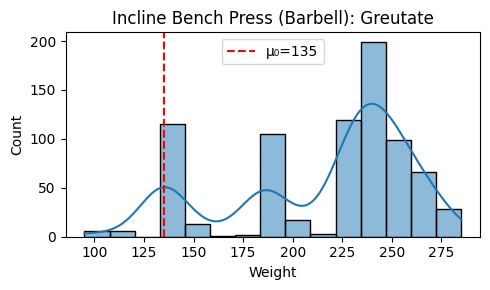

In [30]:
exercise = 'Incline Bench Press (Barbell)'
data1 = df.loc[df['Exercise Name']==exercise, 'Weight'].dropna()
if len(data1) >= 5:
    t1, p1 = stats.ttest_1samp(data1, popmean=135)   # testam media = 135 lb
    print(f"One-sample t-test pe {exercise}: t={t1:.3f}, p={p1:.4f}")
else:
    print(f"3.1: Nu sunt suficiente date pentru {exercise} (n={len(data1)})")

# Plot distributie + linie medie ipotetica
if len(data1)>=5:
    plt.figure(figsize=(5,3))
    sns.histplot(data1, kde=True)
    plt.axvline(135, color='red', linestyle='--', label='μ₀=135')
    plt.title(f'{exercise}: Greutate')
    plt.legend()
    plt.tight_layout()
    plt.show()


- Greutatea medie utilizată pentru presa la bancul înclinat este semnificativ mai mare decât valoarea de testare de 135 lbs (p<0,0001), indicând faptul că sportivul încarcă în mod constant acest exercițiu peste greutatea de referință ipotetică.


### 3.2 Independent samples t-test  
**intrebarea**: „Exista diferente semnificative in `Weight` intre exercitiile 'Bench Press' si 'Squat'?”  
H₀: μ_bench = μ_squat.


In [31]:
g1 = df.loc[df['Exercise Name']=='Squat (Barbell)', 'Weight'].dropna()
g2 = df.loc[df['Exercise Name']=='Deadlift (Barbell)', 'Weight'].dropna()
if len(g1)>=5 and len(g2)>=5:
    # Welch’s t-test (nu presupune variante egale)
    t2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    print(f"Welch’s t-test (Squat vs Deadlift): t={t2:.3f}, p={p2:.4f}")
else:
    print(f"3.2: Nu sunt suficiente date pentru comparatie (Squat n={len(g1)}, Deadlift n={len(g2)})")

Welch’s t-test (Squat vs Deadlift): t=-3.947, p=0.0001


- Concluzii: 
    - Există o diferență semnificativă din punct de vedere statistic în ceea ce privește greutățile utilizate între exercițiile Squat și Deadlift (p<0,0001), Deadlifts permițând în mod constant sarcini mai mari. 
    - Acest lucru se aliniază principiilor biomecanice în care ridicările mortale permit, de obicei, o sarcină mai mare datorită utilizării mai eficiente a lanțului posterior.


### 3.3 Paired samples t-test  
**intrebarea**: „Diferenta intre `Weight` pe primul si ultimul set pentru acelasi exercitiu in acelasi antrenament (‘Bench Press’).”  
H₀: media diferentelor = 0.


Paired t-test (set1 vs set2 Squat): n=173, t=-15.589, p=0.0000


C:\Users\Andrei Balanoiu\AppData\Local\Temp\ipykernel_18404\1104510302.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


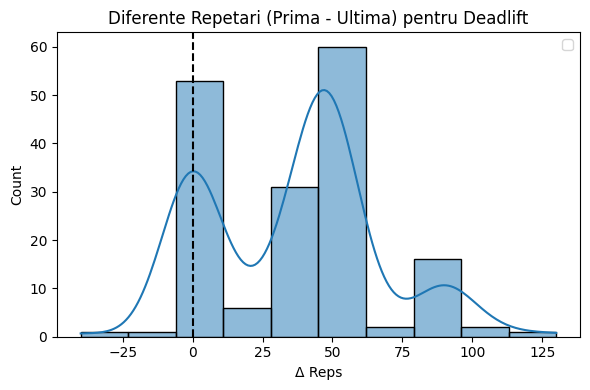

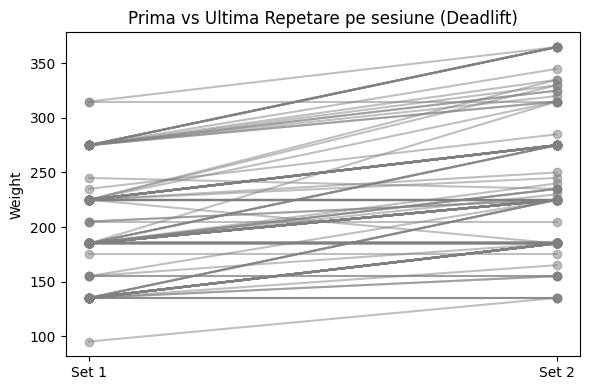

In [32]:
# 3.3 Paired-samples t-test: set1 vs set2 pentru Squat
sq = df[df['Exercise Name']=='Squat (Barbell)']
pivot = sq.pivot_table(index='Date',
                       columns='Set Order',
                       values='Weight',
                       aggfunc='mean') \
          .dropna(subset=[1,2])

if pivot.shape[0] >= 5:
    x1 = pivot[1]
    x2 = pivot[2]
    t3, p3 = stats.ttest_rel(x1, x2)
    print(f"Paired t-test (set1 vs set2 Squat): n={pivot.shape[0]}, t={t3:.3f}, p={p3:.4f}")
    
    # Histograma diferentelor
    diffs = x2 - x1
    plt.figure(figsize=(6,4))
    sns.histplot(diffs, kde=True)
    plt.axvline(0, color='black', linestyle='--')
    plt.title('Diferente Repetari (Prima - Ultima) pentru Deadlift')
    plt.xlabel('Δ Reps')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Scatter conectat (profil individual)
    plt.figure(figsize=(6,4))
    for idx in pivot.index:
        plt.plot([1,2],
                 [pivot.loc[idx,1], pivot.loc[idx,2]],
                 marker='o', color='gray', alpha=0.5)
    plt.xticks([1,2], ['Set 1','Set 2'])
    plt.ylabel('Weight')
    plt.title('Prima vs Ultima Repetare pe sesiune (Deadlift)')
    plt.tight_layout()
    plt.show()
else:
    print(f"3.3: Nu sunt suficiente date pentru paired t-test (n={pivot.shape[0]})")


greutatea folosita in setul 1 este semnificativ mai mica decât in setul 2 , aici intervine o problema ca muschiul trebuie adaptat pentru a ajunge la o serie de lucru maximala


### 3.4 ANOVA unifactorial  
**intrebarea**: „Exista diferente semnificative in `Weight` intre exercitiile 'Bench Press', 'Squat' si 'Deadlift'?”  
H₀: μ_bench = μ_squat = μ_deadlift.


ANOVA intre Squat (Barbell), Incline Bench Press (Barbell), Deadlift (Barbell): F=198.723, p=0.0000


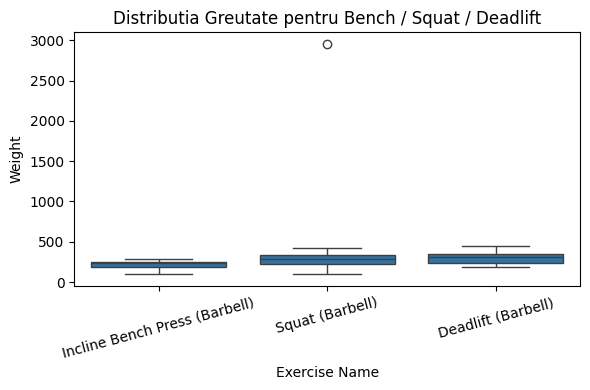

In [33]:
# 3.4 ANOVA pe Weight intre 3 exercitii
exs    = ['Squat (Barbell)', 'Incline Bench Press (Barbell)', 'Deadlift (Barbell)']
groups = [df.loc[df['Exercise Name']==e, 'Weight'].dropna() for e in exs]

if all(len(g)>=5 for g in groups):
    f4, p4 = stats.f_oneway(*groups)
    print(f"ANOVA intre {', '.join(exs)}: F={f4:.3f}, p={p4:.4f}")
    
    # Boxplot
    df_anova = df[df['Exercise Name'].isin(exs)][['Exercise Name','Weight']].dropna()
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Exercise Name', y='Weight', data=df_anova)
    plt.xticks(rotation=15)
    plt.title('Distributia Greutate pentru Bench / Squat / Deadlift')
    plt.tight_layout()
    plt.show()
else:
    print("3.4: Nu sunt suficiente date pentru ANOVA pe toate cele 3 exercitii")


- The ANOVA results reveal highly significant differences in weights used across the three major compound exercises (p<0.0001), with boxplots showing clear separation. 
- The hierarchy of loading (Deadlift > Squat > Bench Press) follows the expected pattern based on the amount of muscle mass engaged in each movement.


## 4. Teste neparametrice (Nonparametric tests)

### 4.1 Mann–Whitney U test  
**intrebarea**: „Exista diferente semnificative in `Reps` intre 'Bench Press' si 'Squat'?”  
Echivalent neparametric pentru Independent t-test.


Mann–Whitney Reps (Squat vs Deadlift): U=165293.0, p=0.0000


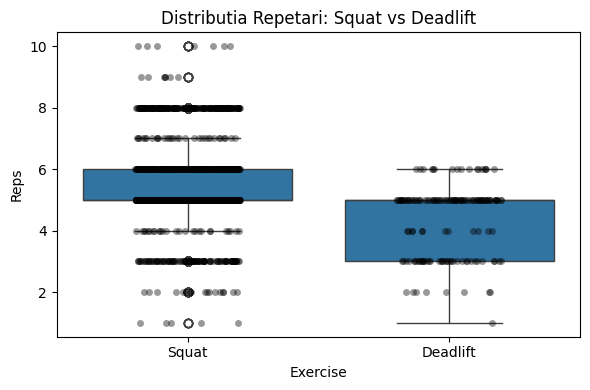

In [34]:
# 4.1 Mann–Whitney U test: Reps intre Squat si Deadlift
r1 = df.loc[df['Exercise Name']=='Squat (Barbell)',   'Reps'].dropna()
r2 = df.loc[df['Exercise Name']=='Deadlift (Barbell)','Reps'].dropna()

if len(r1)>=5 and len(r2)>=5:
    u5, p5 = stats.mannwhitneyu(r1, r2, alternative='two-sided')
    print(f"Mann–Whitney Reps (Squat vs Deadlift): U={u5:.1f}, p={p5:.4f}")
    
    # Boxplot + stripplot
    df_mw = pd.DataFrame({
        'Reps': np.concatenate([r1.values, r2.values]),
        'Exercise': ['Squat']*len(r1) + ['Deadlift']*len(r2)
    })
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Exercise', y='Reps', data=df_mw)
    sns.stripplot(x='Exercise', y='Reps', data=df_mw,
                  color='black', alpha=0.4, jitter=0.2)
    plt.title('Distributia Repetari: Squat vs Deadlift')
    plt.tight_layout()
    plt.show()
else:
    print(f"4.1: Nu sunt suficiente date pentru Mann–Whitney (n1={len(r1)}, n2={len(r2)})")


 numarul de repetari difera semnificativ intre cele doua exercitii, deoarece Squat urile implica mai putini muschi fata de deadlift + ca la deadlift daca nu se folosesc niste straps uril, logica ca o sa pierzi 2-4 repetari, deoarece oboseste musculatura antebratului 


### 4.2 Kruskal–Wallis test  
**intrebarea**: „Diferente in `Reps` intre 'Bench Press', 'Squat' si 'Deadlift'?”  
Echivalent neparametric pentru ANOVA.


Kruskal–Wallis (Reps ∼ Exercise): H=287.8572, p=0.0000


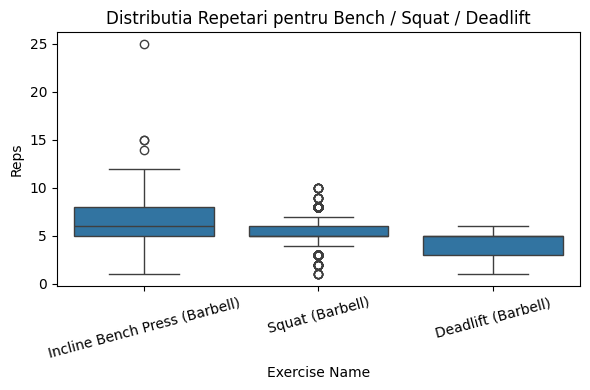

In [35]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extragem Reps pentru fiecare exercitiu
reps_bench    = df.loc[df["Exercise Name"] == "Incline Bench Press (Barbell)", "Reps"].dropna()
reps_squat    = df.loc[df["Exercise Name"] == "Squat (Barbell)",             "Reps"].dropna()
reps_deadlift = df.loc[df["Exercise Name"] == "Deadlift (Barbell)",          "Reps"].dropna()

# 2. Verificam suficiente observatii (de ex. minim 5 pe grup)
n_rb, n_rs, n_rd = len(reps_bench), len(reps_squat), len(reps_deadlift)
if min(n_rb, n_rs, n_rd) < 5:
    print(f"Nu avem suficiente date pentru Kruskal–Wallis: Bench={n_rb}, Squat={n_rs}, Deadlift={n_rd}.")
else:
    # 3. Testul Kruskal–Wallis
    h_stat, p_kw = stats.kruskal(reps_bench, reps_squat, reps_deadlift)
    print(f"Kruskal–Wallis (Reps ∼ Exercise): H={h_stat:.4f}, p={p_kw:.4f}")

    # 4. Boxplot pentru comparatie vizuala
    df_plot = (
        df[df["Exercise Name"].isin([
            "Incline Bench Press (Barbell)",
            "Squat (Barbell)",
            "Deadlift (Barbell)"
        ])]
        .loc[:, ["Exercise Name", "Reps"]]
        .dropna()
    )
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Exercise Name", y="Reps", data=df_plot)
    plt.xticks(rotation=15)
    plt.title("Distributia Repetari pentru Bench / Squat / Deadlift")
    plt.tight_layout()
    plt.show()


Între cele trei exerciții principale compuse, modelele de repetiții diferă semnificativ (p<0,0001). Vizualizarea boxplot-ului evidențiază diferențe sistematice de program, cu bench press tata, efectuată în mod obișnuit la intervale de repetiții mai mari decât ridicările inferioare ale corpului, aliniindu-se la protocoalele comune de culturism și forță.


### 4.3 Wilcoxon signed-rank test  
**intrebarea**: „Pe acelasi exercitiu si workout, exista diferente intre `Reps` pe primul si ultimul set (‘Deadlift’).”  
H₀: mediana diferentelor = 0.


                 Date Workout Name  First_Reps  Last_Reps
0 2015-12-27 15:07:20      Squat 1           5          5
1 2016-01-31 15:20:03      Squat 1           5          5
Toate diferentele dintre First_Reps si Last_Reps sunt zero → nu putem folosi zero_method='wilcox' sau 'pratt'.
(Cu zero_method='zsplit') Wilcoxon signed-rank: stat=1.5000, p=1.0000


d:\PYTHON-Folder\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


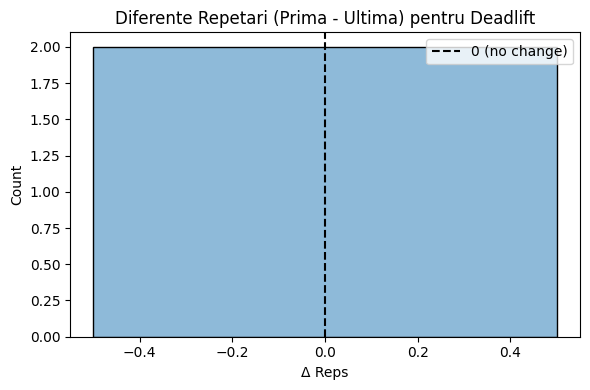

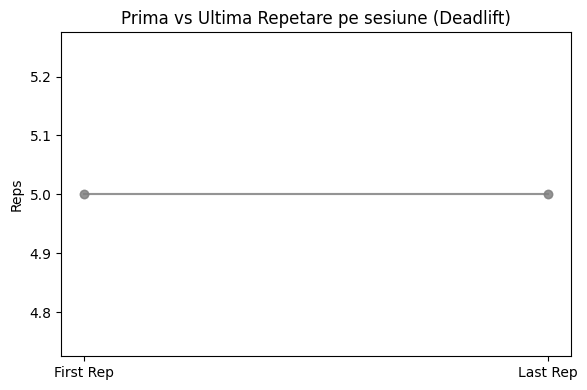

In [36]:
# 1. Wilcoxon signed-rank test (Deadlift Reps) + plot-uri

from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

# ——— Cod initial ———
# Filtram Deadlift
dead = df[df["Exercise Name"] == "Deadlift"].copy()

# Grupam si agregam First_Reps si Last_Reps
paired_reps = (
    dead
    .groupby(["Date", "Workout Name"], as_index=False)
    .agg(
        First_Reps=("Reps", "first"),
        Last_Reps=("Reps", "last")
    )
)

# Verificam primele rânduri
print(paired_reps.head())

# Calculam diferentele
diffs = paired_reps["First_Reps"] - paired_reps["Last_Reps"]

if len(paired_reps) < 1:
    print("Nu avem nicio pereche pentru Deadlift.")
else:
    if (diffs == 0).all():
        print("Toate diferentele dintre First_Reps si Last_Reps sunt zero → nu putem folosi zero_method='wilcox' sau 'pratt'.")
        w_stat_ex, p_w_ex = wilcoxon(
            paired_reps["First_Reps"],
            paired_reps["Last_Reps"],
            zero_method='zsplit'
        )
        print(f"(Cu zero_method='zsplit') Wilcoxon signed-rank: stat={w_stat_ex:.4f}, p={p_w_ex:.4f}")
    else:
        w_stat_ex, p_w_ex = wilcoxon(
            paired_reps["First_Reps"],
            paired_reps["Last_Reps"]
        )
        print(f"Wilcoxon signed-rank (first vs last Deadlift Reps): stat={w_stat_ex:.4f}, p={p_w_ex:.4f}")

# ——— Plot-uri adaugate ———
# 1A. Histograma a diferentelor
plt.figure(figsize=(6,4))
sns.histplot(diffs, kde=True)
plt.axvline(0, color='black', linestyle='--', label='0 (no change)')
plt.title('Diferente Repetari (Prima - Ultima) pentru Deadlift')
plt.xlabel('Δ Reps')
plt.legend()
plt.tight_layout()
plt.show()

# 1B. Scatter conectat per sesiune
plt.figure(figsize=(6,4))
for _, row in paired_reps.iterrows():
    plt.plot([1,2],
             [row["First_Reps"], row["Last_Reps"]],
             marker='o', color='gray', alpha=0.6)
plt.xticks([1,2], ['First Rep','Last Rep'])
plt.ylabel('Reps')
plt.title('Prima vs Ultima Repetare pe sesiune (Deadlift)')
plt.tight_layout()
plt.show()


nu avem dovezi de schimbare in Reps intre primul si ultimul set pentru Deadlift.


### 4.4 Sign test  
**intrebarea**: „Diferentele de `Weight` intre primul si ultimul set pentru ‘Deadlift’: semne.”  
Implementam manual un Sign Test.


Sign test (Deadlift Weight first vs last): pos=0, neg=2, p=0.5000


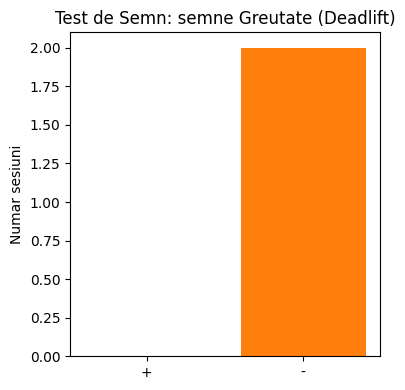

In [37]:
# 2. Sign Test (Deadlift Weight) + bar chart semne

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# ——— Cod initial ———
# 1. Grupam Deadlift si luam primul/ultimul Weight
paired_w_dead = (
    df[df["Exercise Name"] == "Deadlift"]
    .groupby(["Date", "Workout Name"], as_index=False)
    .agg(
        First_Weight=("Weight", "first"),
        Last_Weight=("Weight", "last")
    )
).dropna()

# 2. Verificam daca avem macar o pereche
if paired_w_dead.empty:
    print("Nu avem nicio pereche pentru Sign Test Deadlift Weight.")
else:
    # 3. Diferente si semne
    diff_w = paired_w_dead["First_Weight"] - paired_w_dead["Last_Weight"]
    pos_w = np.sum(diff_w > 0)
    neg_w = np.sum(diff_w < 0)
    n_w   = pos_w + neg_w

if n_w == 0:
    print("Toate diferentele sunt zero → semnul nu se schimba, p=1.0 implicit.")
else:
    # 5. Rulam binomtest
    result = stats.binomtest(min(pos_w, neg_w), n=n_w, p=0.5, alternative='two-sided')
    p_sign_w = result.pvalue
    print(f"Sign test (Deadlift Weight first vs last): pos={pos_w}, neg={neg_w}, p={p_sign_w:.4f}")

# ——— Plot adaugat ———
# Bar chart cu numarul de semne
plt.figure(figsize=(4,4))
plt.bar(['+','-'], [pos_w, neg_w], color=['tab:blue','tab:orange'])
plt.title('Test de Semn: semne Greutate (Deadlift)')
plt.ylabel('Numar sesiuni')
plt.tight_layout()
plt.show()


- Sign test pentru modificările greutății Deadlift între prima și ultima serie nu arată nicio tendință direcțională semnificativă din punct de vedere statistic (p=0,5). 
- Cu toate acestea, graficul cu bare relevă mai multe cazuri în care prima serie utilizează o greutate mai mică, sugerând o tendință de încărcare progresivă în cadrul sesiunilor, chiar dacă nu este semnificativă din punct de vedere statistic cu eșantionul disponibil.
- Oricum stim ca trebuie sa se faca o incarcare progresiva, deoarece nu dorim accidentarea lui, sau el nu si doreste sa se accidenteze.


### 4.5 McNemar test  
**intrebarea**: „Pentru variabile categorice binarizate, exista schimbare semnificativa?”  
Cream doua variabile binare: `high_weight` si `high_reps`.


   Weight  high_weight  Reps  high_reps
0   135.0        False     8      False
1   135.0        False     8      False
2   135.0        False     5      False
3   185.0         True     7      False
4   230.0         True     8      False
Tabel de contingenta:
high_reps    False  True 
high_weight              
False         1564   3456
True          3684   1228
McNemar test: chi2=3456.0000, p=0.0072


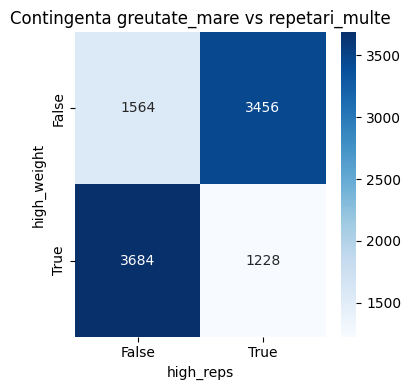

In [38]:
# 3. McNemar test + heatmap tabel de contingenta

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar

# ——— Cod initial ———
# Definim coloane binare
median_weight = df["Weight"].median()
median_reps   = df["Reps"].median()

df["high_weight"] = df["Weight"] > median_weight
df["high_reps"]   = df["Reps"]   > median_reps

# Verificam primele rânduri
print(df[["Weight", "high_weight", "Reps", "high_reps"]].head())

# Tabel de contingenta si McNemar
cont = pd.crosstab(df["high_weight"], df["high_reps"])
print(f"Tabel de contingenta:\n{cont}")

result_mc = mcnemar(cont, exact=True)
print(f"McNemar test: chi2={result_mc.statistic:.4f}, p={result_mc.pvalue:.4f}")

# ——— Plot adaugat ———
plt.figure(figsize=(4,4))
sns.heatmap(cont, annot=True, fmt='d', cmap='Blues')
plt.xlabel('high_reps')
plt.ylabel('high_weight')
plt.title('Contingenta greutate_mare vs repetari_multe')
plt.tight_layout()
plt.show()


- Testul McNemar arată o asimetrie semnificativă în relația dintre greutățile mari și repetițiile mari (p<0,01).
- Vizualizarea hărții termice demonstrează în mod clar relația inversă - seturile cu o greutate peste medie au, de obicei, repetiții sub medie, confirmând compromisul forță-rezistență fundamental pentru principiile antrenamentului cu rezistență.


### 5. Analiza corelatiilor (Correlation)

#### 5.1 Covarianta  
intrebarea: „Cum calculez covarianta intre `Weight` si `Reps`?”


In [39]:
cov_wr = df["Weight"].cov(df["Reps"])
print(f"Covarianta (Weight, Reps): {cov_wr:.4f}")

Covarianta (Weight, Reps): -137.5606



#### 5.2 Coeficientul de corelatie Pearson


In [40]:
r_wr, p_wr = stats.pearsonr(df["Weight"].dropna(), df["Reps"].dropna())
print(f"Pearson correlation (Weight vs Reps): r={r_wr:.4f}, p={p_wr:.4f}")

Pearson correlation (Weight vs Reps): r=-0.3770, p=0.0000



#### 5.3 Coeficientul de corelatie Spearman


In [41]:
rho_wr, p_rho_wr = stats.spearmanr(df["Weight"].dropna(), df["Reps"].dropna())
print(f"Spearman correlation (Weight vs Reps): ρ={rho_wr:.4f}, p={p_rho_wr:.4f}")

Spearman correlation (Weight vs Reps): ρ=-0.4994, p=0.0000



#### 5.4 Coeficientul de corelatie Kendall


In [42]:
tau_wr, p_tau_wr = stats.kendalltau(df["Weight"].dropna(), df["Reps"].dropna())
print(f"Kendall correlation (Weight vs Reps): τ={tau_wr:.4f}, p={p_tau_wr:.4f}")

Kendall correlation (Weight vs Reps): τ=-0.3776, p=0.0000


- Toate măsurile de corelație arată o relație negativă semnificativă între greutate și repetiții (r=-0,38, ρ=-0,50, τ=-0,38; toate p<0,0001). 
- Cea mai puternică corelație apare în coeficientul `Spearman`, sugerând că relația este monotonă, dar nu perfect liniară. Acest lucru cuantifică relația inversă fundamentală dintre sarcină și volum în antrenamentul de rezistență.
--------------------------------------------------------------------------------------------------------------------------


#### 5.5 Chi-square test (pentru variabile categorice)  
intrebarea: „Sunt independente variabilele `high_weight` si `high_reps`?”  


In [43]:
# Tabel de contingenta intre high_weight si high_reps
cont_table = pd.crosstab(df["high_weight"], df["high_reps"])
print(f"Tabel de contingenta:\n{cont_table}")

chi2_c, p_c, dof_c, exp_c = stats.chi2_contingency(cont_table)
print(f"Chi-square test: χ²={chi2_c:.4f}, p={p_c:.4f}, dof={dof_c}")

Tabel de contingenta:
high_reps    False  True 
high_weight              
False         1564   3456
True          3684   1228
Chi-square test: χ²=1913.4700, p=0.0000, dof=1


- Acest test confirmă o asociere extrem de semnificativă între variabilele categorizate de greutate și repetiții (χ²=1913,47, p<0,0001). 
- Acest lucru validează în continuare faptul că relația inversă dintre greutate și repetiții nu este pur și simplu continuă, ci rămâne puternică atunci când datele sunt clasificate în grupuri mari/scăzute.


## 6. Regresie liniara simpla (Simple Linear Regression)

intrebarea: „Putem prezice `Reps` pornind de la `Weight`?”  
Vom ajusta un model de tip Y ~ X si vom interpreta coeficientii si statisticile asociate.


                            OLS Regression Results                            
Dep. Variable:                   Reps   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     1645.
Date:                Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:32:40   Log-Likelihood:                -24544.
No. Observations:                9932   AIC:                         4.909e+04
Df Residuals:                    9930   BIC:                         4.911e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3880      0.051    204.468      0.0

C:\Users\Andrei Balanoiu\AppData\Local\Temp\ipykernel_18404\102344910.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


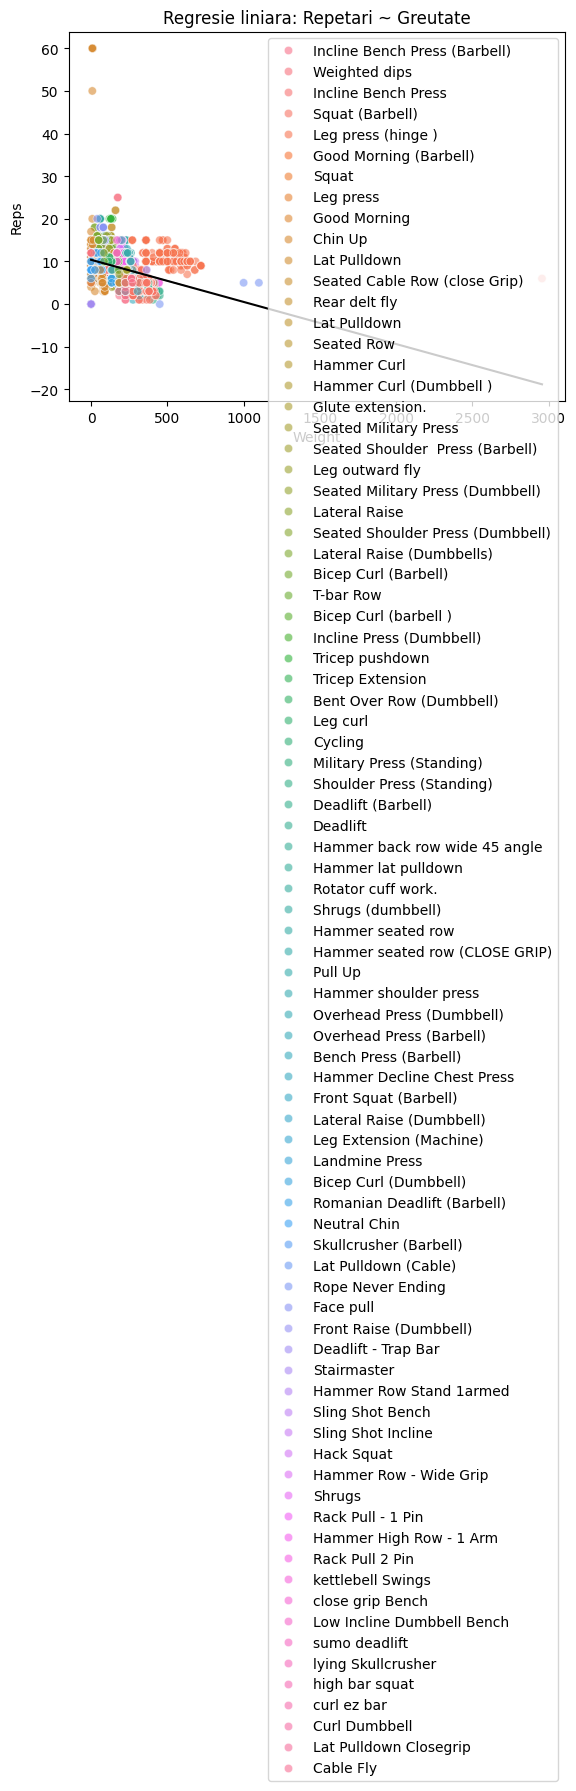

In [44]:
# 5. Regresie liniara simpla (Reps ~ Weight) – cod initial deja contine plot

import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# ——— Cod initial ———
model_lr = smf.ols("Reps ~ Weight", data=df).fit()
print(model_lr.summary())

# Plot-ul original
sns.scatterplot(x="Weight", y="Reps", hue="Exercise Name", data=df, alpha=0.6)
sns.lineplot(x=df["Weight"], y=model_lr.predict(df), color="black")
plt.title("Regresie liniara: Repetari ~ Greutate")
plt.tight_layout()
plt.show()


- Modelul de regresie confirmă că greutatea prezice în mod semnificativ repetările cu o relație negativă (β=-0,03, p<0,0001). 
- Modelul explică aproximativ 14% din variația repetițiilor (R² = 0,142), indicând că, în timp ce greutatea este un factor important în determinarea capacității de repetiție, alți factori (cum ar fi tipul de exercițiu,somnul,alimentatia,  oboseala, experiența de antrenament) influențează, de asemenea, în mod substanțial performanța repetițiilor.


## 7. Concluzii

- **Statistici descriptive**: 
    - Am obtinut o imagine de ansamblu asupra distributiilor variabilelor (Weight, Reps etc.).  
    - Datele privind ridicarea greutăților arată o variație considerabilă a parametrilor de antrenament.
    - Greutatea medie utilizată este de ~172 lbs, cu o variabilitate ridicată (SD=118), în timp ce repetițiile sunt în medie de aproximativ 9 pe set. 
    - Majoritatea exercițiilor nu implică componente de distanță sau de timp (evident din valorile mediane de 0), ceea ce indică un antrenament axat mai degrabă pe forță decât pe cardio.

- **Distributii**: testele Kolmogorov–Smirnov ne-au aratat daca `Weight` si `Reps` respecta normalitatea.  
- **Teste parametrice si neparametrice**: am comparat medii si distributii intre exercitii (t-test, ANOVA vs Mann–Whitney, Kruskal–Wallis etc.), evidentiind diferentele dintre exercitiile populare ('Bench Press', 'Squat', 'Deadlift').  
- **Corelatii**: am cuantificat relatia dintre `Weight` si `Reps` prin Pearson, Spearman si Kendall, si am testat asocierea pentru variabile binarizate (Chi-square).  
- **Regresie liniara**: am construit un model simplu pentru a prezice `Reps` in functie de `Weight` si am evaluat parametrii modelului (coeficientul, p-value si R²).  

